In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
import random

In [2]:
img_dict = defaultdict(lambda: [])

In [3]:
for i in range(3):
    filename = 'images/clock-{}.jpg'.format(i+1)
    img = cv2.imread(filename)
    img_dict['clock'].append(img)

img_dict['theta'].append(cv2.imread('images/theta-1.jpg'))
img_dict['omnicron'].append(cv2.imread('images/omnicron-1.jpg'))

In [4]:
drawer = [
    'toht',
    'ty',
    'chat',
    'tui',
    'tui2',
    'futurama'
]
data_size = 10

for d in drawer:
    for i in range(data_size):
        filename = 'images/{}-{}.jpg'.format(d, i+1)
        img = cv2.imread(filename)
        img_dict[d].append(img)

<Figure size 720x720 with 0 Axes>

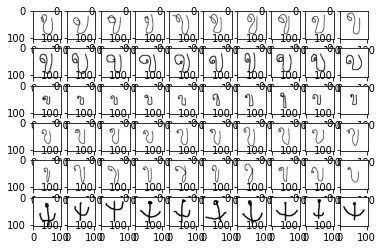

In [5]:
plt.figure(figsize=(10, 10))

f, axarr = plt.subplots(len(drawer), data_size)
for i in range(len(drawer)):
    for j in range(data_size):
        axarr[i][j].imshow(img_dict[drawer[i]][j])
plt.show()

In [6]:
img = img_dict['tui'][0]

In [7]:
img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [8]:
img.shape

(105, 105, 3)

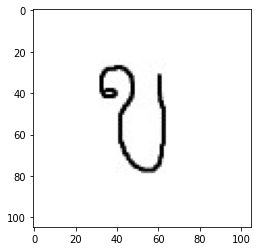

In [9]:
plt.imshow(img)

In [10]:
def find_centroid(img):
    weighted_sum_x, weighted_sum_y, total_sum = 0, 0, 0
    shape = img.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            weighted_sum_x += img[i][j] * i
            weighted_sum_y += img[i][j] * j
            total_sum += img[i][j]
    return (weighted_sum_x / total_sum, weighted_sum_y / total_sum)

def find_contours(img, tolerant=0.05):
    #set a thresh
    thresh = 100
    #get threshold image
    ret, thresh_img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
    #find contours
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    img_area = img.shape[0] * img.shape[1]
    clean_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        diff = abs(img_area - area)
        if diff > tolerant * img_area:
            clean_contours.append(cnt)
            
    return clean_contours    

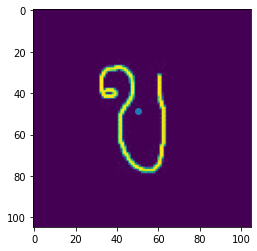

In [11]:
def show_centroid(img):
    centroid = find_centroid(img)
    plt.scatter(centroid[0], centroid[1])
    plt.imshow(img)
    
def invert(img):
    return 255-img
    
show_centroid(invert(img_grey))

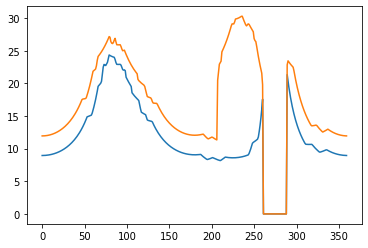

In [12]:
from itertools import chain

def get_intersect(p1, p2, centroid, angle):
    A = np.array([p1, p2])
    B = np.array([centroid, [centroid[0] + 1, centroid[1] + np.tan(angle * np.pi / 180)]])
    t, s = np.linalg.solve(np.array([A[1] - A[0], B[0] - B[1]]).T, B[0] - A[0])
    return (1-t) * A[0] + t * A[1]


def cross_centroid_y_raycast(p1, p2, centroid):
    A = np.array([p1, p2])
    B = np.array([centroid, (centroid[0] + 1, centroid[1])])
    try:
        t, s = np.linalg.solve(np.array([A[1] - A[0], B[0] - B[1]]).T, B[0] - A[0])
    except:
        return False
    intersect = (1-t) * A[0] + t * A[1]
    return 0 <= t <= 1 and intersect[0] > centroid[0]


def get_angle(p, centroid):
    zeta = 180 * np.arctan2(p[1] - centroid[1], p[0] - centroid[0]) / np.pi
    if zeta < 0:
        zeta += 360
    return zeta


def get_dist(p1, p2):
    return np.linalg.norm(p1 - p2)

def get_min_max_radial_distance(img):
    contours = find_contours(img)
    centroid = np.array(find_centroid(img))
    min_dist, max_dist = np.ones(360) * np.inf, np.zeros(360)
    for cnt in contours:
        for i in range(len(cnt)):
            p1, p2 = cnt[i][0], cnt[(i+1)%len(cnt)][0]
            a1, a2 = get_angle(p1, centroid), get_angle(p2, centroid)
            if a1 > a2:
                a1, a2, p1, p2 = a2, a1, p2, p1
            if cross_centroid_y_raycast(p1, p2, centroid):
                angles = chain(range(0, np.ceil(a1).astype('int')),range(np.ceil(a2).astype('int'), 360))
            else:
                angles = range(np.ceil(a1).astype('int'), np.ceil(a2).astype('int'))
            for angle in angles:
                intersect = get_intersect(p1, p2, centroid, angle)
                dist = get_dist(intersect, centroid)
                min_dist[angle] = min(min_dist[angle], dist)
                max_dist[angle] = max(max_dist[angle], dist)
    min_dist = np.minimum(min_dist, max_dist)
    return min_dist, max_dist

def show_ts(img):
    dist = get_min_max_radial_distance(img)
    plt.plot(dist[0])
    plt.plot(dist[1])
    plt.show()
    
show_ts(img_grey)

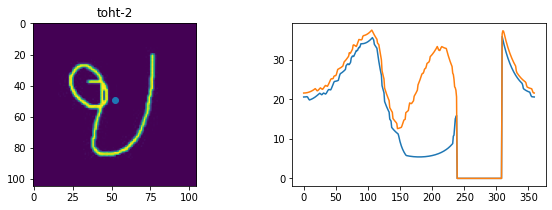

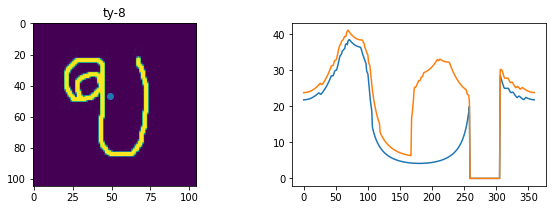

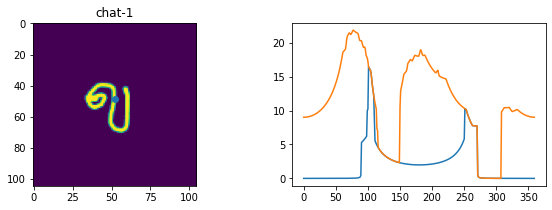

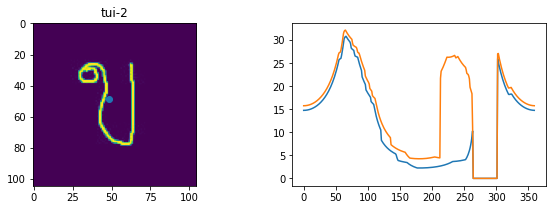

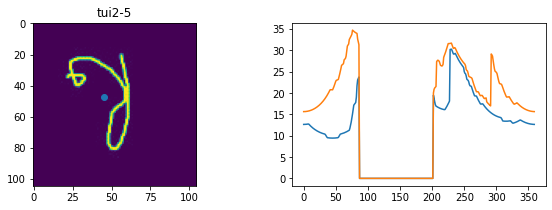

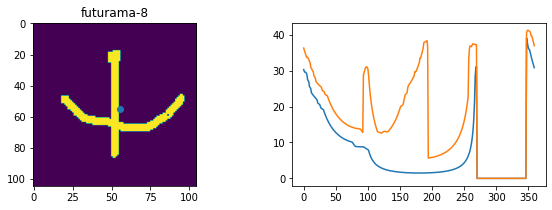

In [13]:
def visualize_alphabet_ts(img, title=""):
    if img.shape[2] > 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = invert(img)
    
    f, axarr = plt.subplots(1, 2, figsize=(10, 3))
    
    centroid = find_centroid(img)
    axarr[0].scatter(centroid[0], centroid[1])
    axarr[0].imshow(img)
    axarr[0].title.set_text(title)
    
    dist = get_min_max_radial_distance(img)
    axarr[1].plot(dist[0])
    axarr[1].plot(dist[1])

for d in drawer:
    n = random.randint(1, 10)
    fname = '{}-{}'.format(d, n)
    img = img_dict[d][n-1]
    visualize_alphabet_ts(img, fname)

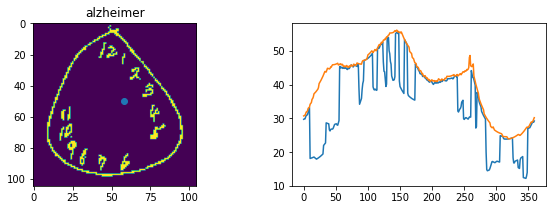

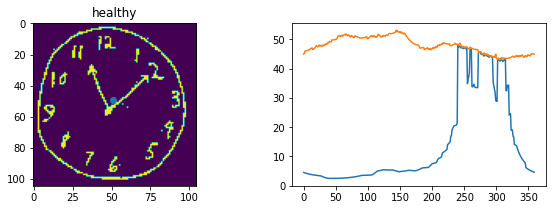

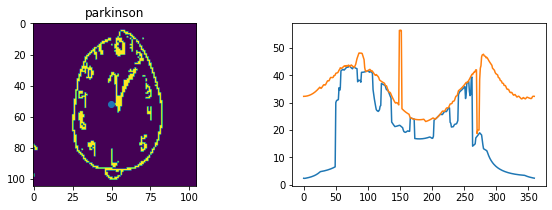

In [14]:
clock_label = ['alzheimer', 'healthy', 'parkinson']
for i, label in enumerate(clock_label):
    img = img_dict['clock'][i-1]
    _, img = cv2.threshold(img,245,255,cv2.THRESH_BINARY)
    visualize_alphabet_ts(img, label)

In [15]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [16]:
%%time
dist = get_min_max_radial_distance(img)

Wall time: 165 ms


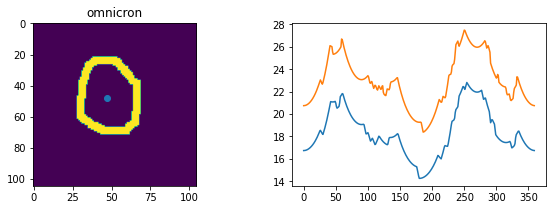

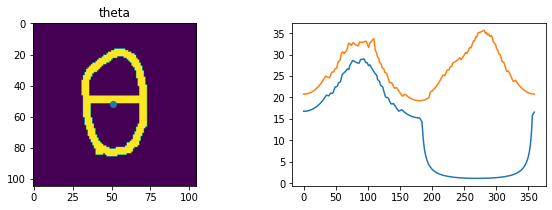

In [17]:
visualize_alphabet_ts(img_dict['omnicron'][0], 'omnicron')
visualize_alphabet_ts(img_dict['theta'][0], 'theta')

In [18]:
# import copy

# #define filter function
# def filter(xL, xR, yL, yR):
#     #initialize variable
#     xLfilter = copy.deepcopy(xL)
#     xRfilter = copy.deepcopy(xR)
#     yLfilter = copy.deepcopy(yL)
#     yRfilter = copy.deepcopy(yR)
    
#     #trim 0 at head and tail of list
#     for i in range(len(xLfilter)):
#         no0headL = False
#         no0headR = False
#         no0tailL = False
#         no0tailR = False
#         #screen at head
#         if xLfilter[0] == 0:
#             xLfilter.pop(0)
#             xRfilter.pop(0)
#             yLfilter.pop(0)
#             yRfilter.pop(0)
#         else:
#             no0headL = True
#         if xRfilter[0] == 0:
#             xLfilter.pop(0)
#             xRfilter.pop(0)
#             yLfilter.pop(0)
#             yRfilter.pop(0)
#         else:
#             no0headR = True
#         #screen at tail    
#         if xLfilter[-1] == 0:
#             xLfilter.pop(-1)
#             xRfilter.pop(-1)
#             yLfilter.pop(-1)
#             yRfilter.pop(-1)
#         else:
#             no0tailL = True
#         if xRfilter[-1] == 0:
#             xLfilter.pop(-1)
#             xRfilter.pop(-1)
#             yLfilter.pop(-1)
#             yRfilter.pop(-1)
#         else:
#             no0tailR = True
#         #when no 0 at head and tail
#         if no0headL and no0headR and no0tailL and no0tailR:
#             break
    
#     #replace 0 in the middle with mean

#     #L side
#     for i in range(len(xLfilter)-2):
#         nextisnot0 = False
#         if xLfilter[i+1] == 0:
#             n_zero = 0
#             for j in range(i+1,len(xLfilter)):
#                 if xLfilter[j] == 0:
#                     n_zero += 1
#                 else:
#                     nextisnot0 = True
#                     n_region = n_zero+1
#                     break
#         if nextisnot0:
#             stepx = (xLfilter[i+n_region]-xLfilter[i])/n_region
#             stepy = (yLfilter[i+n_region]-yLfilter[i])/n_region
#             for j in range(n_zero):
#                 xLfilter[i+j+1] = xLfilter[i]+(j+1)*stepx
#                 yLfilter[i+j+1] = yLfilter[i]+(j+1)*stepy

#     #R side
#     for i in range(len(xRfilter)-2):
#         nextisnot0 = False
#         if xRfilter[i+1] == 0:
#             n_zero = 0
#             for j in range(i+1,len(xRfilter)):
#                 if xRfilter[j] == 0:
#                     n_zero += 1
#                 else:
#                     nextisnot0 = True
#                     n_region = n_zero+1
#                     break
#         if nextisnot0:
#             stepx = (xRfilter[i+n_region]-xRfilter[i])/n_region
#             stepy = (yRfilter[i+n_region]-yRfilter[i])/n_region
#             for j in range(n_zero):
#                 xRfilter[i+j+1] = xRfilter[i]+(j+1)*stepx
#                 yRfilter[i+j+1] = yRfilter[i]+(j+1)*stepy

#     tfilter = [i for i in range(len(xLfilter))]
#     #------------------------------------------------
#     #return after clear out 0
#     return xLfilter, xRfilter, tfilter

# def gen_inf_smooth_padding(arr):
#     padR = []
#     padL = []
#     for i in range(len(arr)):
#         padR.append(arr[i])
#         if not np.isinf(arr[i]):
#             break

#     for i in range(len(arr)):
#         padL.append(arr[len(arr)-1-i])
#         if not np.isinf(arr[len(arr)-1-i]):
#             break
    
#     padL = np.flip(padL)
#     padR = np.array(padR)
#     return padL, padR

# def inf_smooth(arr):
#     padL, padR = gen_inf_smooth_padding(arr)
#     L_bound = 0
#     R_bound = len(arr)
#     if np.isinf(arr[0]):
#         arr = np.concatenate((padL, arr))
#         L_bound += len(padL)
#         R_bound += len(padL)
#     if np.isinf(arr[-1]):52.20931587 52.07472101
#         arr = np.concatenate((arr, padR))
        
#     arr += 1
#     arr = np.where(np.isinf(arr), 0, arr)
#     arr = list(arr)
#     arr, _, _ = filter(arr, arr, arr, arr)
#     arr = np.array(arr)
#     arr -= 1
#     arr = arr[L_bound:R_bound]
#     return arr

In [19]:
# def get_min_max_radial_distance(img):
#     contours = find_contours(img)
#     centroid = find_centroid(img)
#     min_dist, max_dist = np.ones(360) * np.inf, np.zeros(360)
#     shape = img.shape
#     for i in range(shape[0]):
#         for j in range(shape[1]):
#             if img[i][j]:
#                 continue
#             r = np.sqrt((i-centroid[0])**2 + (j-centroid[1])**2)
#             zeta = 180 * np.arctan((i-centroid[0])/(j-centroid[1])) / np.pi
#             if j < centroid[0]:
#                 #Q2, Q3
#                 zeta += 180
#             elif i < centroid[0] and j > centroid[0]:
#                 #Q4
#                 zeta += 360
#             zeta = np.round(zeta).astype('int')
#             if zeta >= 360:
#                 zeta -= 360
#             min_dist[zeta] = min(min_dist[zeta], r)
#             max_dist[zeta] = max(max_dist[zeta], r)
#     min_dist = inf_smooth(min_dist)
#     max_dist = inf_smooth(max_dist)
#     min_dist = moving_average(min_dist)
#     max_dist = moving_average(max_dist)
#     return min_dist, max_dist


# dist = get_min_max_radial_distance(img_grey)
# plt.plot(dist[0])
# plt.plot(dist[1])
# plt.show()